In [1]:
### source: https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial#3D-plotting-the-scan

In [2]:
%matplotlib inline

import numpy as np
import SimpleITK as sitk
import glob

import matplotlib.pyplot as plt

from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

INPUT_FOLDER = r'D:/masters_datasets/LUNA16-original/LUNA16_Images/*.mhd'
exams = glob.glob(INPUT_FOLDER)
print(len(exams))
exams.sort()

888


In [3]:
itkimage = sitk.ReadImage(exams[0])
ct_scan = sitk.GetArrayFromImage(itkimage)
origin = np.array(list(reversed(itkimage.GetOrigin())))
spacing = np.array(list(reversed(itkimage.GetSpacing())))

#### Loading the files

In [4]:
def load_scan(path):
  itkimage = sitk.ReadImage(path)
  return sitk.GetArrayFromImage(itkimage)

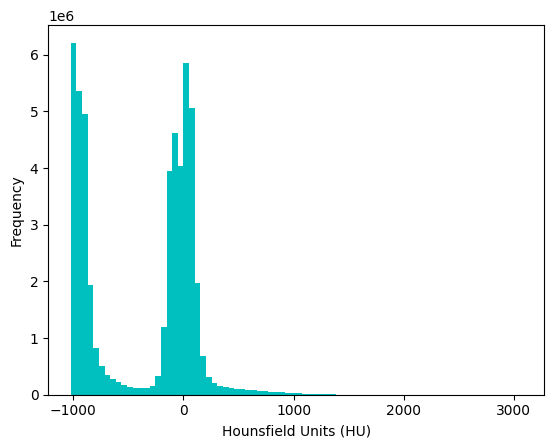

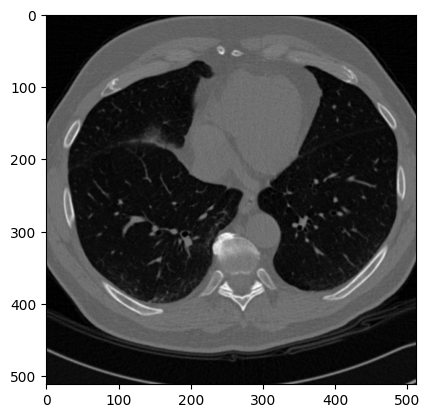

In [5]:
first_exam_pixels = load_scan(exams[0])
plt.hist(first_exam_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

plt.imshow(first_exam_pixels[80], cmap=plt.cm.gray)
plt.show()

#### Resampling

In [6]:
first_exam_pixels = load_scan(exams[0])
print(first_exam_pixels.shape)
# first_exam_pixels = load_scan(exams[1])
# print(first_exam_pixels.shape)

(194, 512, 512)


#### 3D plotting the scan

In [12]:
def plot_3d(image, threshold=-300):
  p = image.transpose(2, 1, 0)

  verts, faces, normals, values = measure.marching_cubes(p, threshold)

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  mesh = Poly3DCollection(verts[faces], alpha=0.70)
  face_color = [0.45, 0.45, 0.75]
  mesh.set_facecolor(face_color)
  ax.add_collection3d(mesh)

  ax.set_xlim(0, p.shape[0])
  ax.set_ylim(0, p.shape[1])
  ax.set_zlim(0, p.shape[2])

  ax.view_init(20, 90)

  plt.show()

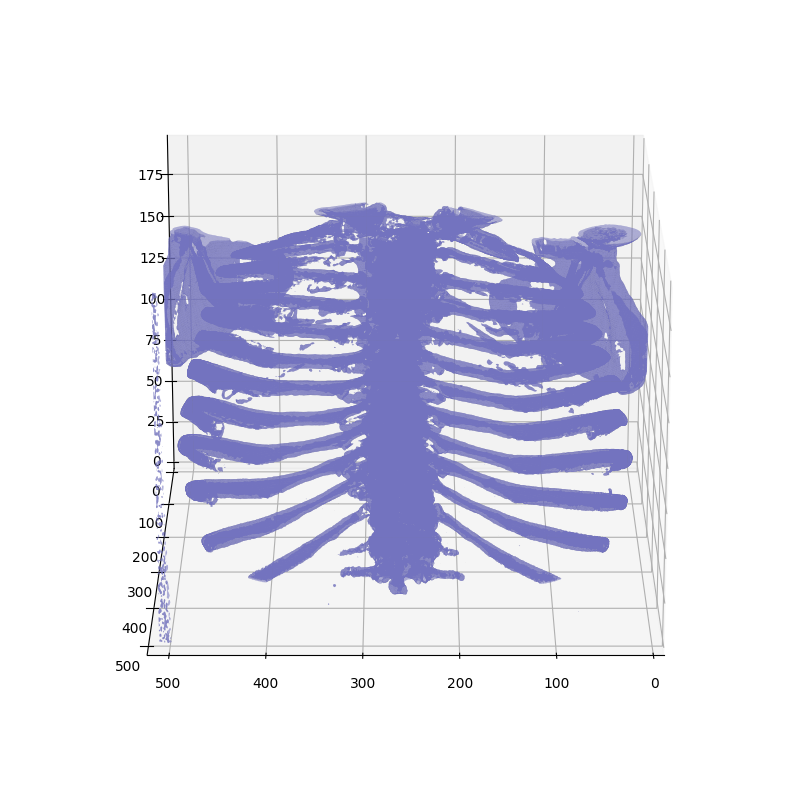

In [13]:
plot_3d(first_exam_pixels, 400)

#### Lung segmentation

In [14]:
def largest_label_volume(im, bg=-1):
  vals, counts = np.unique(im, return_counts=True)

  counts = counts[vals != bg]
  vals = vals[vals != bg]

  if len(counts) > 0:
    return vals[np.argmax(counts)]
  else:
    return None
  
def segment_lung_mask(image, fill_lung_structures=True):
    
  # not actually binary, but 1 and 2. 
  # 0 is treated as background, which we do not want
  binary_image = np.array(image > -320, dtype=np.int8)+1
  labels = measure.label(binary_image)
  
  # Pick the pixel in the very corner to determine which label is air.
  #   Improvement: Pick multiple background labels from around the patient
  #   More resistant to "trays" on which the patient lays cutting the air 
  #   around the person in half
  background_label = labels[0,0,0]
  
  #Fill the air around the person
  binary_image[background_label == labels] = 2
  
  
  # Method of filling the lung structures (that is superior to something like 
  # morphological closing)
  if fill_lung_structures:
    # For every slice we determine the largest solid structure
    for i, axial_slice in enumerate(binary_image):
      axial_slice = axial_slice - 1
      labeling = measure.label(axial_slice)
      l_max = largest_label_volume(labeling, bg=0)
      
      if l_max is not None: #This slice contains some lung
        binary_image[i][labeling != l_max] = 1

  
  binary_image -= 1 #Make the image actual binary
  binary_image = 1-binary_image # Invert it, lungs are now 1
  
  # Remove other air pockets insided body
  labels = measure.label(binary_image, background=0)
  l_max = largest_label_volume(labels, bg=0)
  if l_max is not None: # There are air pockets
    binary_image[labels != l_max] = 0

  return binary_image

In [15]:
segmented_lungs = segment_lung_mask(first_exam_pixels, False)
segmented_lungs_fill = segment_lung_mask(first_exam_pixels, True)

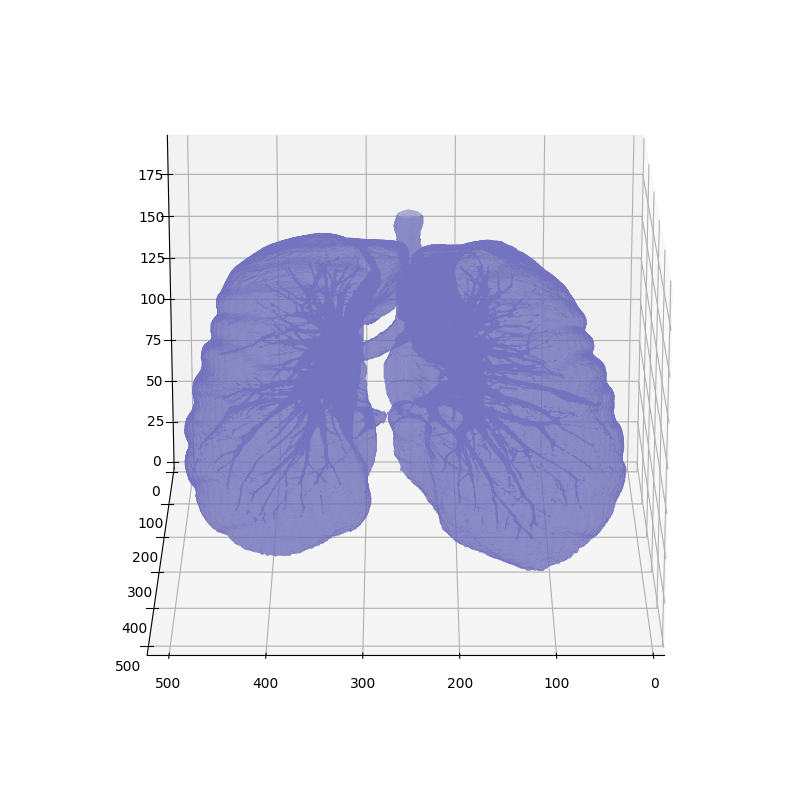

In [16]:
plot_3d(segmented_lungs, 0)

In [17]:
print(type(segmented_lungs))
print(segmented_lungs.shape)
print(np.max(segmented_lungs))
print(np.min(segmented_lungs))

<class 'numpy.ndarray'>
(194, 512, 512)
1
0


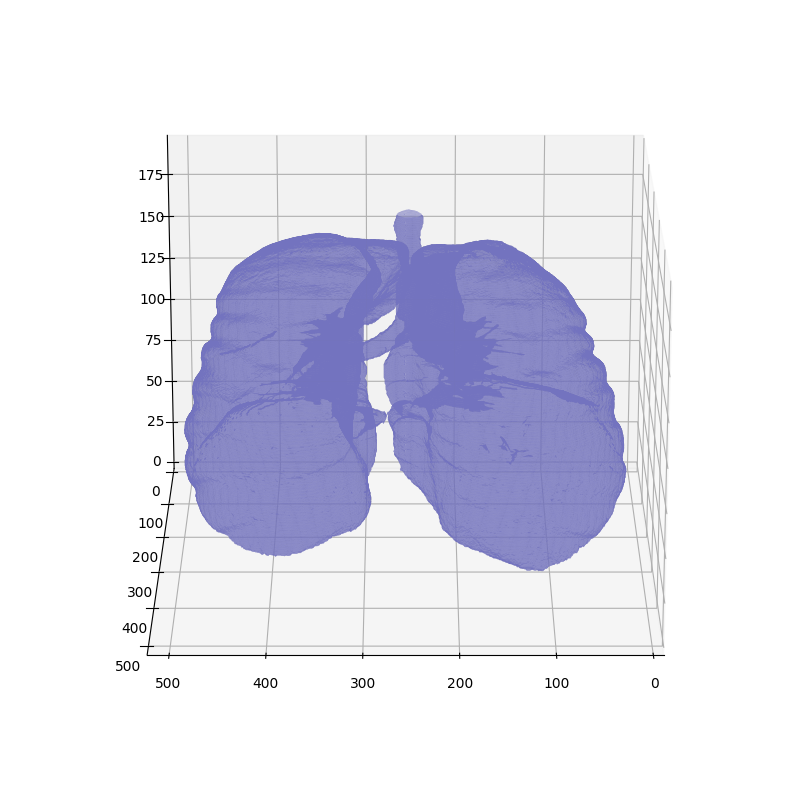

In [18]:
plot_3d(segmented_lungs_fill, 0)

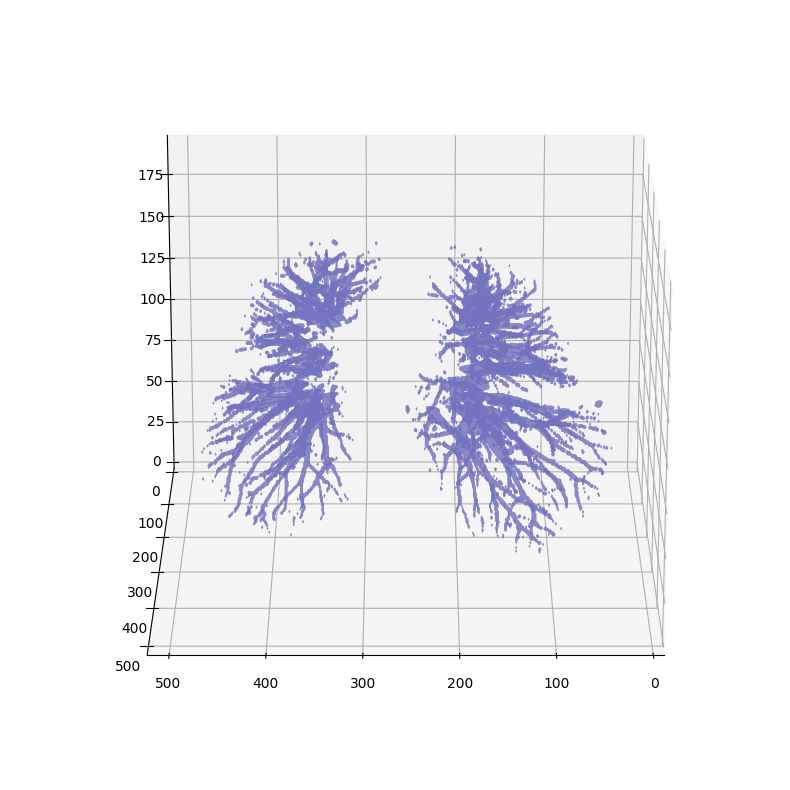

In [19]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

#### Normalization

In [20]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

#### Zero centering

In [21]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image